# AutoGluon

AutoGluon aims to provide automatic machine learning (Auto ML) support for MXNet and Gluon. AutoGluon focuses on automatic deep learning (Auto DL). AutoGluon targets: 

* *Beginners *are* *70~80% of the customers who would be interested in AutoGluon. The basic Auto ML  scenario: customers have a traditional machine learning task by hand, provide own raw data, watch the search process, and finally obtain a good quality model. The beginners include but not limited to engineers and students, who are generally new to machine learning. 
* *Advanced users *aim to own full control and access to the Auto ML overall process as well as each important component, such as constructing own networks, metrics, losses, optimizers, searcher and trial scheduler. The advanced users could potentially have more specified constraints regarding to the automatic searching procedure. The advanced users include but not limited to experienced machine learning researchers and engineers.
* *Contributors: *Contributors are Advanced users who will create strategies that are useful for beginners either extending to new datasets, new domains, new algorithms or bringing state of art results to save time and effort.

The AutoGluon's design principles are:

* *Easy to use: *Deep learning framework users could use AutoGluon almost right away. The only usage difference between AutoGluon and Gluon is that: rather than providing a fixed value to different deep learning components, we enable a searchable range to let Auto ML decides which are the best, whereas all the major APIs' usage stays the same.
* *Easy to extend: *From user perspective, we organize the AutoGluon by tasks, users could easily use all the task specific components, such as data preprocessing, model zoo, metrics and losses, so that adding a new task could very straightforward. In this way, advanced ML tasks, such as GAN ,could be easily incorporated by providing a new task module. From system perspective, multiple back-ends could be used since the front-end are designed to be separate from the backends, this could be beneficial to extend to production-level Auto ML.

In the following*, we use Image Classification as a running example* to illustrate the usage of AutoGluon's main APIs.


## Preparation

### Install AutoGluon

```bash
git clone ssh://git.amazon.com/pkg/AutoGluon
cd AutoGluon
python setup.py develop
```

### Import Task

We are using image classification as an example in this notebook.

In [1]:
from autogluon import image_classification as task

import logging
logging.basicConfig(level=logging.INFO)

## A Quick Image Classification Example

We first show the most basic usage by first creating a dataset and then fiting the dataset to generate the results with the image classification example.

### Create AutoGluon Dataset

We use CIFAR10 for image classfication for demo purpose.

In [2]:
dataset = task.Dataset(name='cifar10') # case insentive 
# TODO. show a quick summary of the dataset, e.g. #example for train, #classes

The constructed dataset contains the `gluon.data.DataLoader` for the CIFAR10 training and validation datasets.

In [3]:
dataset.train[0] # access the first example
dataset.val[-10:] # access the last 10 validation examples

(
 [[[[ 84 120  98]
    [ 98 125 103]
    [ 99 125 105]
    ...
    [178 190 169]
    [166 169 152]
    [160 170 145]]
 
   [[142 158 145]
    [187 182 170]
    [171 168 153]
    ...
    [190 200 179]
    [176 177 161]
    [178 185 161]]
 
   [[181 192 183]
    [190 196 184]
    [177 185 175]
    ...
    [175 184 169]
    [169 169 156]
    [181 186 166]]
 
   ...
 
   [[ 17  16  11]
    [ 12  11  11]
    [ 22  19  15]
    ...
    [114 118 107]
    [117 120 112]
    [115 125 113]]
 
   [[  8   9   7]
    [ 28  22  20]
    [ 91  83  65]
    ...
    [123 128 118]
    [110 113 104]
    [114 123 113]]
 
   [[ 44  38  31]
    [104  97  79]
    [137 142 128]
    ...
    [141 148 141]
    [127 132 127]
    [ 85  90  81]]]
 
 
  [[[114 142 197]
    [115 143 197]
    [116 144 199]
    ...
    [120 147 201]
    [120 147 201]
    [119 146 200]]
 
   [[118 145 198]
    [119 146 199]
    [120 146 201]
    ...
    [124 150 201]
    [124 149 201]
    [124 149 201]]
 
   [[122 147 201]
    [123 149 202

Then we will use the default configuration of the image classification to generate:
* Best result of the search in terms of accuracy
* According best configuration regarding to the best result
    
To acheive this, we are using `fit` function to generate the above results based on the datasets.

The default configruation is based on `max_trial_count=2` and `max_training_epochs=10`. This will take approximately 10min to finish.

INFO:autogluon.scheduler.fifo:Starting Experiments
INFO:autogluon.scheduler.fifo:Num of Finished Tasks is 0
INFO:autogluon.scheduler.fifo:Num of Pending Tasks is 2
INFO:autogluon.searcher.searcher:Finished Task with config: {"fitspace:model": "cifar_resnet20_v1", "fitspace:optimizer": "adam", "fitspace:lr": 0.06417074631491246, "fitspace:momentum": 0.8736173807889697, "fitspace:pretrained": true} and reward: 0.41876
INFO:autogluon.searcher.searcher:Finished Task with config: {"fitspace:model": "cifar_resnet110_v1", "fitspace:optimizer": "adam", "fitspace:lr": 0.0008893578173207074, "fitspace:momentum": 0.9366694137744673, "fitspace:pretrained": false} and reward: 0.41779
INFO:autogluon.scheduler.fifo:Saving Training Curve in checkpoint/exp1.png


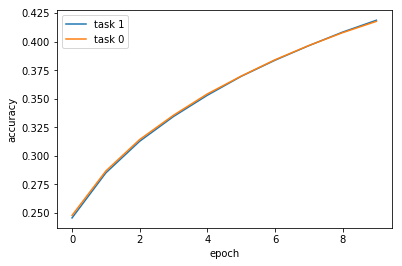

In [4]:
results = task.fit(dataset)

The best accuracy is:

In [5]:
print(results.val_accuracy)

0.41876


The associated best configuration is:

In [6]:
print(results.config)

{'fitspace:model': 'cifar_resnet20_v1', 'fitspace:optimizer': 'adam', 'fitspace:lr': 0.06417074631491246, 'fitspace:momentum': 0.8736173807889697, 'fitspace:pretrained': True}


Total time cost is:

In [7]:
print('%.2f s' % results.time)

163.99 s


## A Step-by-step Image Classification Example

We first introduce the basic configuration `autogluon.space`, which is used to represent the search space of each task components, we will then go throught each components, including 

* `autogluon.Dataset`
* `autogluon.Nets`
* `autogluon.Optimizers`
* `autogluon.Losses`
* `autogluon.Metrics`

and finally put all together to `fit` to generate best results.

### Import AutoGluon

In [8]:
import warnings
warnings.filterwarnings("ignore")

import autogluon as ag

### Create AutoGluon Space


`autogluon.space` is a search space containing a set of configuration candidates.
We provide three basic space types.

* Categorical Space

In [9]:
list_space = ag.space.List('listspace', ['0', '1', '2'])
print(list_space)

AutoGluon List Space listspace: ['0', '1', '2']


* Linear Space

In [10]:
linear_space = ag.space.Linear('linspace', 0, 10)
print(linear_space)

AutoGluon Linear Space linspace: lower 0, upper 10


* Log Space

In [11]:
log_space = ag.space.Log('logspace', 10**-10, 10**-1)
print(log_space)

AutoGluon Log Space logspace: lower 0.000000, upper 0.100000


* An Example of Random Sample from the Combined Space

In [12]:
print(ag.space.sample_configuration([list_space, linear_space, log_space]))

Configuration:
  linspace, Value: 1
  listspace, Value: '0'
  logspace, Value: 9.099340845095782e-05



We then will use `autogluon.Nets` and `autogluon.Optimizers` as examples to show the usage of auto objects. The remainining auto objects are using default value.

### Create AutoGluon Nets

`autogluon.Nets` is a list of auto networks, and allows search for the best net

* from a list of provided (or default) networks
* by choosing the best architecture regarding to each auto net.

In [13]:
# type of net_list is ag.space.List

# method 1 (complex but flexiable): specify the net_list using get_model
# net_list = [task.model_zoo.get_model('cifar_resnet20_v1'), # TODO: pretrained and pretrained_dataset would be supported
#             task.model_zoo.get_model('cifar_resnet56_v1'),
#             task.model_zoo.get_model('cifar_resnet110_v1')]

# method 2 (easy and less flexiable): specify the net_list using model name
net_list = ['cifar_resnet20_v1',
            'cifar_resnet56_v1',
            'cifar_resnet110_v1']

# default net list for image classification would be overwritten 
# if net_list is provided
nets = ag.Nets(net_list)

print(nets)

AutoGluon Nets ['cifar_resnet20_v1', 'cifar_resnet56_v1', 'cifar_resnet110_v1'] with Configuration space object:
  Hyperparameters:
    model, Type: Categorical, Choices: {cifar_resnet20_v1, cifar_resnet56_v1, cifar_resnet110_v1}, Default: cifar_resnet20_v1
    pretrained, Type: Categorical, Choices: {True, False}, Default: True
  Conditions:
    pretrained | model in {'cifar_resnet20_v1', 'cifar_resnet56_v1', 'cifar_resnet110_v1'}



### Create AutoGluon Optimizers

`autogluon.Optimizers` defines a list of optimization algorithms that allows search for the best optimization algorithm 

* from a list of provided (or default) optimizers
* by choosing the best hyper-parameters regarding to each auto optimizer

In [14]:
# method 1 (complex but flexiable): specify the optim_list using get_optim
# optimizers = ag.Optimizers([ag.optim.get_optim('sgd'),
#                             ag.optim.get_optim('adam')])

# method 2 (easy and less flexiable): specify the optim_list using get_model
optimizers = ag.Optimizers(['sgd', 'adam'])

print(optimizers)

AutoGluon Optimizers ['sgd', 'adam'] with Configuration space object:
  Hyperparameters:
    lr, Type: UniformFloat, Range: [0.0001, 0.1], Default: 0.0031622777, on log-scale
    momentum, Type: UniformFloat, Range: [0.85, 0.95], Default: 0.9
    optimizer, Type: Categorical, Choices: {sgd, adam}, Default: sgd
  Conditions:
    lr | optimizer in {'sgd', 'adam'}
    momentum | optimizer in {'sgd', 'adam'}



### Create AutoGluon Fit - Put all together

INFO:autogluon.scheduler.fifo:Starting Experiments
INFO:autogluon.scheduler.fifo:Num of Finished Tasks is 0
INFO:autogluon.scheduler.fifo:Num of Pending Tasks is 6
INFO:autogluon.searcher.searcher:Finished Task with config: {"fitspace:model": "cifar_resnet20_v1", "fitspace:optimizer": "sgd", "fitspace:lr": 0.0006970816809350348, "fitspace:momentum": 0.8663384345806123, "fitspace:pretrained": true} and reward: 0.2444
INFO:autogluon.searcher.searcher:Finished Task with config: {"fitspace:model": "cifar_resnet110_v1", "fitspace:optimizer": "sgd", "fitspace:lr": 0.009726943900092279, "fitspace:momentum": 0.9405356358123225, "fitspace:pretrained": true} and reward: 0.2464
INFO:autogluon.searcher.searcher:Finished Task with config: {"fitspace:model": "cifar_resnet56_v1", "fitspace:optimizer": "sgd", "fitspace:lr": 0.010734554017152979, "fitspace:momentum": 0.8832474627323881, "fitspace:pretrained": false} and reward: 0.333675
INFO:autogluon.searcher.searcher:Finished Task with config: {"fits

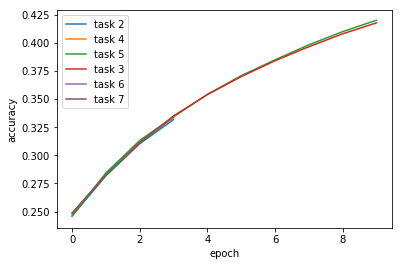

In [15]:
stop_criterion = {
    'time_limits': 1*60*60,
    'max_metric': 0.80,
    'max_trial_count': 6
}

resources_per_trial = {
    'max_num_gpus': 1,
    'max_num_cpus': 4,
    'max_training_epochs': 10
}

results = task.fit(dataset,
                   nets,
                   optimizers,
                   trial_scheduler='hyperband', # early stopping based on hyperband
                   stop_criterion=stop_criterion,
                   resources_per_trial=resources_per_trial)

The best accuracy is:

In [17]:
print(results.val_accuracy)

0.41999


The best associated configuration is:

In [18]:
print(results.config)

{'fitspace:model': 'cifar_resnet20_v1', 'fitspace:optimizer': 'adam', 'fitspace:lr': 0.08424751177252776, 'fitspace:momentum': 0.9403903110536888, 'fitspace:pretrained': True}


Total time cost is:

In [19]:
print('%.2f s' % results.time)

207.93 s


## Refereces

* code: https://code.amazon.com/packages/AutoGluon/trees/heads/mainline 
* API design: https://quip-amazon.com/aaGsAS9lY3WU/AutoGluon-API
* Implementation roadmap: https://quip-amazon.com/zlQUAjSWBc3c/AutoGluon-System-Implementation-Roadmap